In [2]:
from qiskit import QuantumRegister, ClassicalRegister, AncillaRegister, QuantumCircuit
from qiskit.quantum_info import Statevector, Operator
from qiskit_aer import AerSimulator 
from qiskit import transpile, assemble
from qiskit.result.utils import marginal_distribution
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_distribution, plot_state_qsphere
import matplotlib.pyplot as plt
import numpy as np
import math

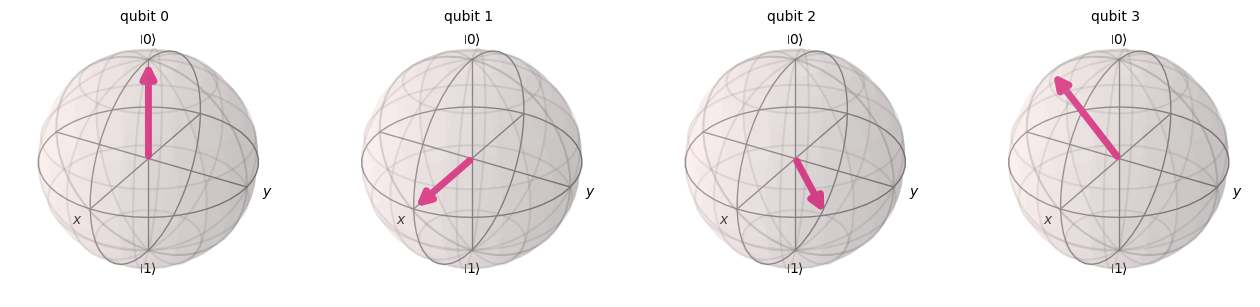

In [5]:
# zero = Statevector(np.array([1,0]))

qc = QuantumCircuit(4)
qc.h(1)
qc.h(2)
qc.rz(np.pi/4, 2)
qc.h(3)
qc.rz(np.pi/4, 3)
qc.h(3)

plot_bloch_multivector(Statevector(qc))

In [37]:
backend2 = AerSimulator()
nq=4

input_vector = np.linspace(start=0, stop=255, num=nq, dtype=int)

phi_data = np.interp(input_vector, (0,255), (0, np.pi)) 

# Generate random phase values
# phi_data =  np.random.uniform(low=0, high=np.pi, size=nq)
# encode data
qc5 = QuantumCircuit(nq,nq)
for iq in range(nq):
    qc5.h(iq)  # Apply Hadamard gate to create superposition on qubit 0
    qc5.p(phi_data[iq], iq)  # Apply the first random phase to qubit 0

qc5.barrier()
# decode data
for iq in range(nq):
    qc5.h(iq)  # Apply another Hadamard gate to see the phase effect as probability

print(Statevector(qc5))

for iq in range(nq):
    qc5.measure(iq,iq)
# Visualize the circuit
print(qc5.draw())

# Run the circuit on a shot-based simulator
shots = 10000  # Number of simulation shots to mimic statistical outcomes
result = backend2.run(qc5, shots=shots).result()
counts = result.get_counts(0)

Statevector([-3.92523115e-17-6.69995273e-18j,
              4.06470994e-18-2.98083545e-33j,
             -2.22546982e-18-6.97299564e-35j,
              1.07035397e-34-5.74836793e-18j,
             -5.40581408e-17+6.70078871e-17j,
             -2.96231841e-34+5.74836793e-18j,
              6.93889390e-18+1.14620566e-17j,
             -4.06470994e-18-2.64542288e-33j,
              1.59798822e-16+4.33012702e-01j,
              6.24149993e-18+3.45366732e-18j,
              2.50000000e-01+5.66201658e-18j,
             -4.55784195e-18+3.36731597e-18j,
              7.50000000e-01-2.39203357e-16j,
              2.58531392e-18-3.36731597e-18j,
             -4.38101534e-17-4.33012702e-01j,
              5.25523592e-18-3.45366732e-18j],
            dims=(2, 2, 2, 2))
     ┌───┐  ┌──────┐  ░ ┌───┐┌─┐         
q_0: ┤ H ├──┤ P(0) ├──░─┤ H ├┤M├─────────
     ├───┤ ┌┴──────┴┐ ░ ├───┤└╥┘┌─┐      
q_1: ┤ H ├─┤ P(π/3) ├─░─┤ H ├─╫─┤M├──────
     ├───┤┌┴────────┤ ░ ├───┤ ║ └╥┘┌─┐   
q_2: ┤ H ├┤ P(2π/3) ├─

In [31]:
#  post processing to recover input: need to marginalize over other qubits
maxDiff=0
output = []
for  iq in range(nq):
    marCnt=marginal_distribution(counts,[iq])
    #print('iq:',iq,marCnt)
    if '1' in marCnt:
        prob=marCnt['1']/shots
    else:
        prob=0
    ev=1-2*prob
    mAng=np.arccos(ev)

    output.append(mAng)

    tAng=phi_data[iq]
    diff=mAng-tAng;  adiff=abs(diff)
    
    if maxDiff < adiff: maxDiff = adiff
    print("q:%d  mProb=%.3f   mAng=%.3f   tAng=%.3f   diff=%7.3f" % (iq,prob , mAng, tAng, diff))
print('maxDiff=%.3f   1/sqrt(shots)=%.3f'%(maxDiff,1/np.sqrt(shots))) 

np.interp(output, (0, np.pi), (0, 255)).astype(int)

q:0  mProb=0.000   mAng=0.000   tAng=0.000   diff=  0.000
q:1  mProb=0.252   mAng=1.051   tAng=1.047   diff=  0.004
q:2  mProb=0.746   mAng=2.086   tAng=2.094   diff= -0.009
q:3  mProb=1.000   mAng=3.142   tAng=3.142   diff=  0.000
maxDiff=0.009   1/sqrt(shots)=0.010


array([  0,  85, 169, 255])

In [3]:
# INPUT
def prepareInput(n=4, input_range=(0, 255), angle_range=(0, np.pi), dist="linear", verbose=1):
    side = int(math.sqrt(n))
    if dist.lower() == "random":
        input_vector = np.random.uniform(low=0, high=255, size=n, dtype=int)
    
    elif dist.lower() == "reversing":
        input_vector = []
        init_vector = np.linspace(start=0, stop=255, num=n, dtype=int)

        for i in range(side):
            input_vector.extend(init_vector[i*side:i*side+side] if not i%2 else init_vector[i*side+side-1:i*side-1:-1])
    else:
        input_vector = np.linspace(start=0, stop=255, num=n, dtype=int)

    input_angles = np.interp(input_vector, input_range, angle_range) 
    
    if verbose:
        plt.title('Input image')
        plt.imshow(np.reshape(input_vector, (side, side)), cmap='gray')

    return input_vector, input_angles

In [49]:
# ENCODER
def phaseEncoder(qc: QuantumCircuit, angles: np.array, measure = False, verbose = False):
    """Add Phase encoding model to a blank circuit.

    Args:
        qc (QuantumCircuit): _description_
        angles (np.array): _description_
        measure (bool, optional): _description_. Defaults to False.
        verbose (bool, optional): _description_. Defaults to False.

    Returns:
        _type_: _description_
    """
    q = QuantumRegister(len(angles), 'q')
    c = ClassicalRegister(len(angles), 'c')

    qc.add_register(q, c)

    for i, ang in enumerate(angles):
        qc.h(i)
        qc.p(ang, i)
    
    qc.barrier()

    for i in range(len(angles)):
        qc.h(i)
        # qc.measure(i, i)

    sv = Statevector(qc)
    if verbose: print(sv)
    
    # for i in range(len(angles)):
    #     # qc.h(i)
    #     qc.measure(i, i)
    if measure: qc.measure(range(len(angles)), range(len(angles)))
    else: qc.barrier()

    return sv

In [6]:
# INVERTER LOGIC
def invertPixels(qc: QuantumCircuit, verbose = False):
    for i in range(qc.num_qubits):
        qc.x(i)

    qc.barrier()

    if verbose: print(qc)
    return qc

In [44]:
# Measurements
def addMeasurements(qc: QuantumCircuit, verbose = False):
    qc.measure(list(range(qc.num_qubits)), list(range(qc.cregs[0].size)))
    
    if verbose: print(f"Adding Measurments:\n{qc}")

    return qc

In [39]:
# SIMULATE
def simulate(qc: QuantumCircuit, shots = 1000000, verbose = False):
    aer_sim = AerSimulator()
    t_qc_image = transpile(qc, aer_sim)
    job = aer_sim.run(t_qc_image, shots=shots)
    result = job.result()
    counts = result.get_counts()

    if verbose:
        print(counts)
        display(plot_histogram(counts))
    
    return counts

In [8]:
# DECODE
def phaseDecoder(counts, n = 4, shots = 1000000, verbose = False):
    reconstruct = []

    for  iq in range(n):
        marCnt=marginal_distribution(counts,[iq])
        #print('iq:',iq,marCnt)
        if '1' in marCnt:
            prob=marCnt['1']/shots
        else:
            prob=0
        ev=1-2*prob
        reconstruct.append(np.arccos(ev))
    
    if verbose: print("Angles: ", reconstruct)

    reconstruct = np.interp(reconstruct, (0, np.pi), (0, 255)).astype(int)

    if verbose: print("Vector: ", reconstruct)

    return list(reconstruct)

In [9]:
def compare_plots(input_vector, output_vector):
    side = int(math.sqrt(len(input_vector)))
    
    print(f"input: {input_vector}")
    print(f"\noutput: {output_vector}")

    print(f"\tDifferences: {[x-y for x,y in zip(input_vector, output_vector)]}")

    print(f"\nexpected INVERT output: {[255-x for x in input_vector]}")
    print(f"\tINVERT Differences: {[x-y for x,y in zip([255-x for x in input_vector], output_vector)]}")

    plt.imshow(np.reshape(input_vector, (side, side)), cmap = 'gray')
    plt.title('Input Image')
    plt.show()
    plt.imshow(np.reshape(output_vector, (side, side)), cmap = 'gray')
    plt.title('Reconstructed Inverted Image')
    plt.show()

Statevector([-3.92523115e-17-6.69995273e-18j,
              4.06470994e-18-2.98083545e-33j,
             -2.22546982e-18-6.97299564e-35j,
              1.07035397e-34-5.74836793e-18j,
             -5.40581408e-17+6.70078871e-17j,
             -2.96231841e-34+5.74836793e-18j,
              6.93889390e-18+1.14620566e-17j,
             -4.06470994e-18-2.64542288e-33j,
              1.59798822e-16+4.33012702e-01j,
              6.24149993e-18+3.45366732e-18j,
              2.50000000e-01+5.66201658e-18j,
             -4.55784195e-18+3.36731597e-18j,
              7.50000000e-01-2.39203357e-16j,
              2.58531392e-18-3.36731597e-18j,
             -4.38101534e-17-4.33012702e-01j,
              5.25523592e-18-3.45366732e-18j],
            dims=(2, 2, 2, 2))

Depth: 3, Width: 4


┌───┐  ┌──────┐  ░ ┌───┐ ░ 
q_0: ┤ H ├──┤ P(0) ├──░─┤ H ├─░─
     ├───┤ ┌┴──────┴┐ ░ ├───┤ ░ 
q_1: ┤ H ├─┤ P(π/3) ├─░─┤ H ├─░─
     ├───┤┌┴────────┤ ░ ├───┤ ░ 
q_2: ┤ H ├┤ P(2π/3) ├─░─┤ H ├─░─
     ├───┤└─┬──────┬┘ ░ ├───┤ ░ 
q_3: ┤ H ├──┤ P(π) ├──░─┤ H ├─░─
     └───┘  └──────┘  ░ └───┘ ░ 
c: 4/═══════════════════════════

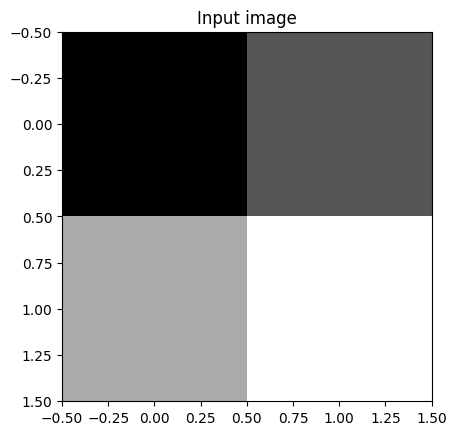

In [50]:
# Setup basic circuit:
circuit = QuantumCircuit()
input_vector, input_angles = prepareInput(n = 4, angle_range=(0, np.pi), verbose=True)

ph_StateVec = phaseEncoder(circuit, angles=input_angles, measure=False)

print(f"{ph_StateVec}\n\nDepth: {circuit.depth()}, Width: {circuit.num_qubits}")
circuit.draw()

<IPython.core.display.Latex object>

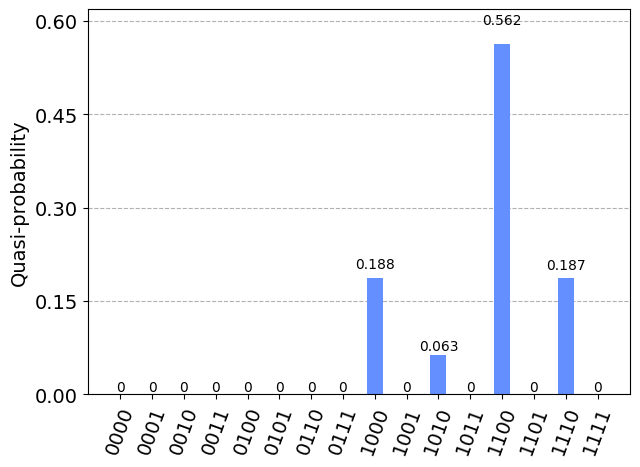

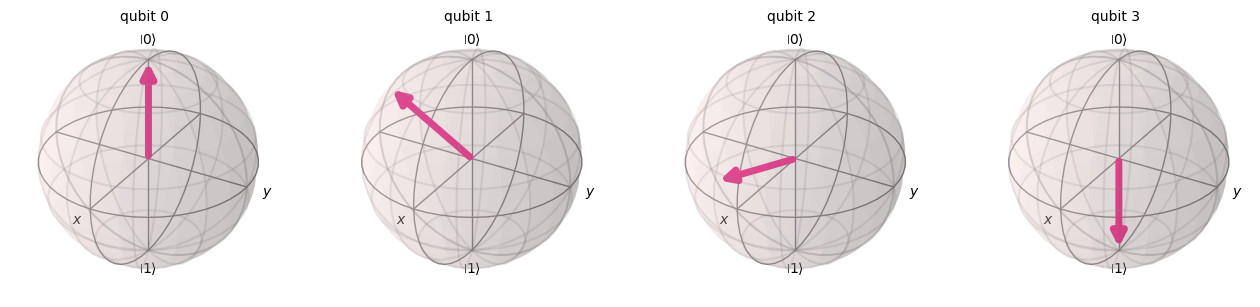

In [47]:
display(ph_StateVec.draw('latex'))

display(plot_distribution(ph_StateVec.probabilities_dict()))

display(plot_bloch_multivector(ph_StateVec))

In [51]:
invertPixels(qc = circuit)
addMeasurements(qc = circuit)
circuit.draw()

┌───┐  ┌──────┐  ░ ┌───┐ ░ ┌───┐ ░ ┌─┐         
q_0: ┤ H ├──┤ P(0) ├──░─┤ H ├─░─┤ X ├─░─┤M├─────────
     ├───┤ ┌┴──────┴┐ ░ ├───┤ ░ ├───┤ ░ └╥┘┌─┐      
q_1: ┤ H ├─┤ P(π/3) ├─░─┤ H ├─░─┤ X ├─░──╫─┤M├──────
     ├───┤┌┴────────┤ ░ ├───┤ ░ ├───┤ ░  ║ └╥┘┌─┐   
q_2: ┤ H ├┤ P(2π/3) ├─░─┤ H ├─░─┤ X ├─░──╫──╫─┤M├───
     ├───┤└─┬──────┬┘ ░ ├───┤ ░ ├───┤ ░  ║  ║ └╥┘┌─┐
q_3: ┤ H ├──┤ P(π) ├──░─┤ H ├─░─┤ X ├─░──╫──╫──╫─┤M├
     └───┘  └──────┘  ░ └───┘ ░ └───┘ ░  ║  ║  ║ └╥┘
c: 4/════════════════════════════════════╩══╩══╩══╩═
                                         0  1  2  3

{'0011': 4601, '0111': 1561, '0101': 526, '0001': 1504}


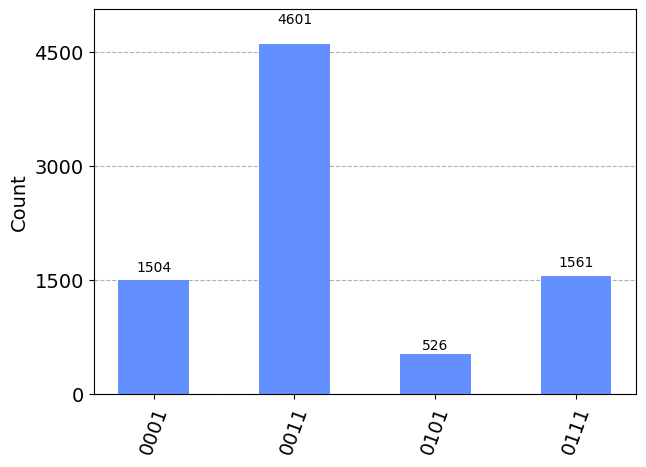

In [52]:
shots = 8192
counts = simulate(qc = circuit, verbose=True, shots=shots)


In [53]:
output_vector = phaseDecoder(counts=counts, n=4, shots=shots, verbose=True)

Angles:  [3.141592653589793, 2.0994769469275334, 1.058157557937201, 0.0]
Vector:  [255 170  85   0]


input: [0, 85, 170, 255]

output: [255, 170, 85, 0]
	Differences: [-255, -85, 85, 255]

expected INVERT output: [255, 170, 85, 0]
	INVERT Differences: [0, 0, 0, 0]


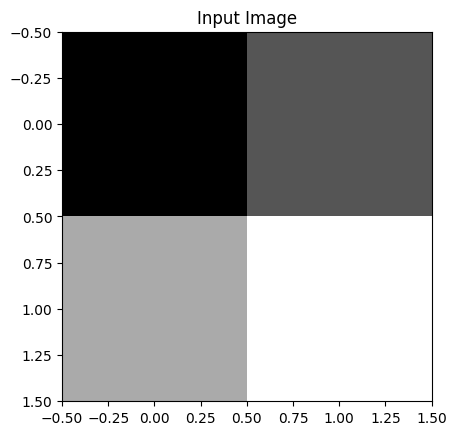

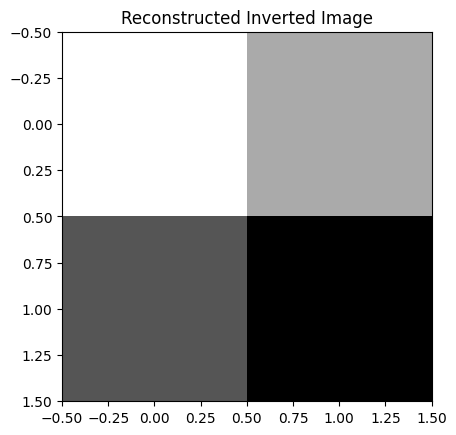

In [54]:
compare_plots(input_vector=list(input_vector), output_vector=output_vector)